# Unit06_tSNE | t-分布隨機鄰域嵌入：高維製程數據視覺化

本 Notebook 使用 `Part_2/data/reactor_operation` 資料夾內的模擬數據來演示 t-SNE (t-distributed Stochastic Neighbor Embedding) 降維與視覺化技術。

## 目標
- 理解 t-SNE 的核心原理與實作方法
- 掌握 t-SNE 關鍵超參數的調整技巧
- 學會使用 scikit-learn 實作 t-SNE 模型
- 比較 t-SNE 與 PCA 的視覺化效果差異
- 應用 t-SNE 於化工製程的多操作模式視覺化

資料背景：模擬批次反應器在三種不同操作模式下的製程數據（低溫低壓、高溫高壓、中溫中壓）

In [6]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit06_tSNE'
SOURCE_DATA_DIR = 'reactor_operation'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")

try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit06'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\data\reactor_operation
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_tSNE
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_tSNE\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit06\outputs\P2_Unit06_tSNE\figs


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# scikit-learn 相關模組
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy.spatial import ConvexHull

# 設定繪圖風格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 設定隨機種子
np.random.seed(42)

print("✓ 套件載入完成")

✓ 套件載入完成


In [8]:
# ========================================
# 2.1 數據生成：三種操作模式
# ========================================

n_samples_per_mode = 200
n_features = 10

# 定義特徵名稱
feature_names = [
    'Reactor_Temp',        # 反應器溫度
    'Reactor_Pressure',    # 反應器壓力
    'Feed_Rate',           # 進料速率
    'Cooling_Rate',        # 冷卻速率
    'Stirring_Speed',      # 攪拌速度
    'Reactant_Conc',       # 反應物濃度
    'Product_Yield',       # 產物產率
    'Energy_Consumption',  # 能耗
    'Reaction_Time',       # 反應時間
    'pH'                   # pH值
]

# 生成三種操作模式的數據
np.random.seed(42)

# 模式 A：低溫低壓操作
mode_A_mean = np.array([375, 1.2, 50, 30, 200, 0.3, 0.75, 150, 60, 6.5])
mode_A_cov = np.diag([10, 0.1, 5, 3, 20, 0.03, 0.05, 15, 5, 0.3])**2
X_mode_A = np.random.multivariate_normal(mode_A_mean, mode_A_cov, n_samples_per_mode)

# 模式 B：高溫高壓操作
mode_B_mean = np.array([475, 2.5, 80, 60, 350, 0.6, 0.92, 350, 45, 7.2])
mode_B_cov = np.diag([15, 0.15, 8, 5, 30, 0.05, 0.04, 25, 6, 0.4])**2
X_mode_B = np.random.multivariate_normal(mode_B_mean, mode_B_cov, n_samples_per_mode)

# 模式 C：中溫中壓操作
mode_C_mean = np.array([425, 1.8, 65, 45, 275, 0.45, 0.83, 250, 52, 6.8])
mode_C_cov = np.diag([12, 0.12, 6, 4, 25, 0.04, 0.045, 20, 5.5, 0.35])**2
X_mode_C = np.random.multivariate_normal(mode_C_mean, mode_C_cov, n_samples_per_mode)

# 合併數據
X = np.vstack([X_mode_A, X_mode_B, X_mode_C])
labels = np.array([0]*n_samples_per_mode + [1]*n_samples_per_mode + [2]*n_samples_per_mode)
mode_names = ['Mode A (Low T/P)', 'Mode B (High T/P)', 'Mode C (Mid T/P)']

# 建立 DataFrame
df = pd.DataFrame(X, columns=feature_names)
df['Mode'] = [mode_names[i] for i in labels]
df['Mode_Label'] = labels

print("✓ 多操作模式數據生成完成")
print(f"  總樣本數: {len(df)}")
print(f"  特徵數: {n_features}")
print(f"  操作模式數: {len(mode_names)}")
print(f"\n模式分布:")
print(df['Mode'].value_counts())

✓ 多操作模式數據生成完成
  總樣本數: 600
  特徵數: 10
  操作模式數: 3

模式分布:
Mode
Mode A (Low T/P)     200
Mode B (High T/P)    200
Mode C (Mid T/P)     200
Name: count, dtype: int64


---
### 3. 數據標準化

In [9]:
# ========================================
# 3.1 標準化處理
# ========================================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✓ 數據標準化完成")
print(f"  標準化後均值: {X_scaled.mean(axis=0)[:3]}")
print(f"  標準化後標準差: {X_scaled.std(axis=0)[:3]}")

✓ 數據標準化完成
  標準化後均值: [-1.67847218e-15 -5.34618646e-15 -2.61050441e-15]
  標準化後標準差: [1. 1. 1.]


---
### 4. t-SNE 降維：不同困惑度的比較

In [10]:
# ========================================
# 4.1 測試多個困惑度值
# ========================================

perplexities = [5, 10, 30, 50, 100]
tsne_results = {}

print("開始執行 t-SNE（不同困惑度）...")
for perp in perplexities:
    print(f"  Perplexity = {perp}...")
    tsne = TSNE(
        n_components=2,
        perplexity=perp,
        learning_rate='auto',
        max_iter=1000,
        init='pca',
        random_state=42
    )
    X_tsne = tsne.fit_transform(X_scaled)
    tsne_results[perp] = {
        'embedding': X_tsne,
        'kl_div': tsne.kl_divergence_,
        'n_iter': tsne.n_iter_
    }
    print(f"    KL divergence: {tsne.kl_divergence_:.4f}, Iterations: {tsne.n_iter_}")

print("\n✓ t-SNE 降維完成（所有困惑度）")

開始執行 t-SNE（不同困惑度）...
  Perplexity = 5...
    KL divergence: 1.0356, Iterations: 999
  Perplexity = 10...
    KL divergence: 1.0036, Iterations: 999
  Perplexity = 30...
    KL divergence: 0.7652, Iterations: 999
  Perplexity = 50...
    KL divergence: 0.5745, Iterations: 999
  Perplexity = 100...
    KL divergence: 0.2650, Iterations: 999

✓ t-SNE 降維完成（所有困惑度）


---
### 5. 視覺化：不同困惑度的比較

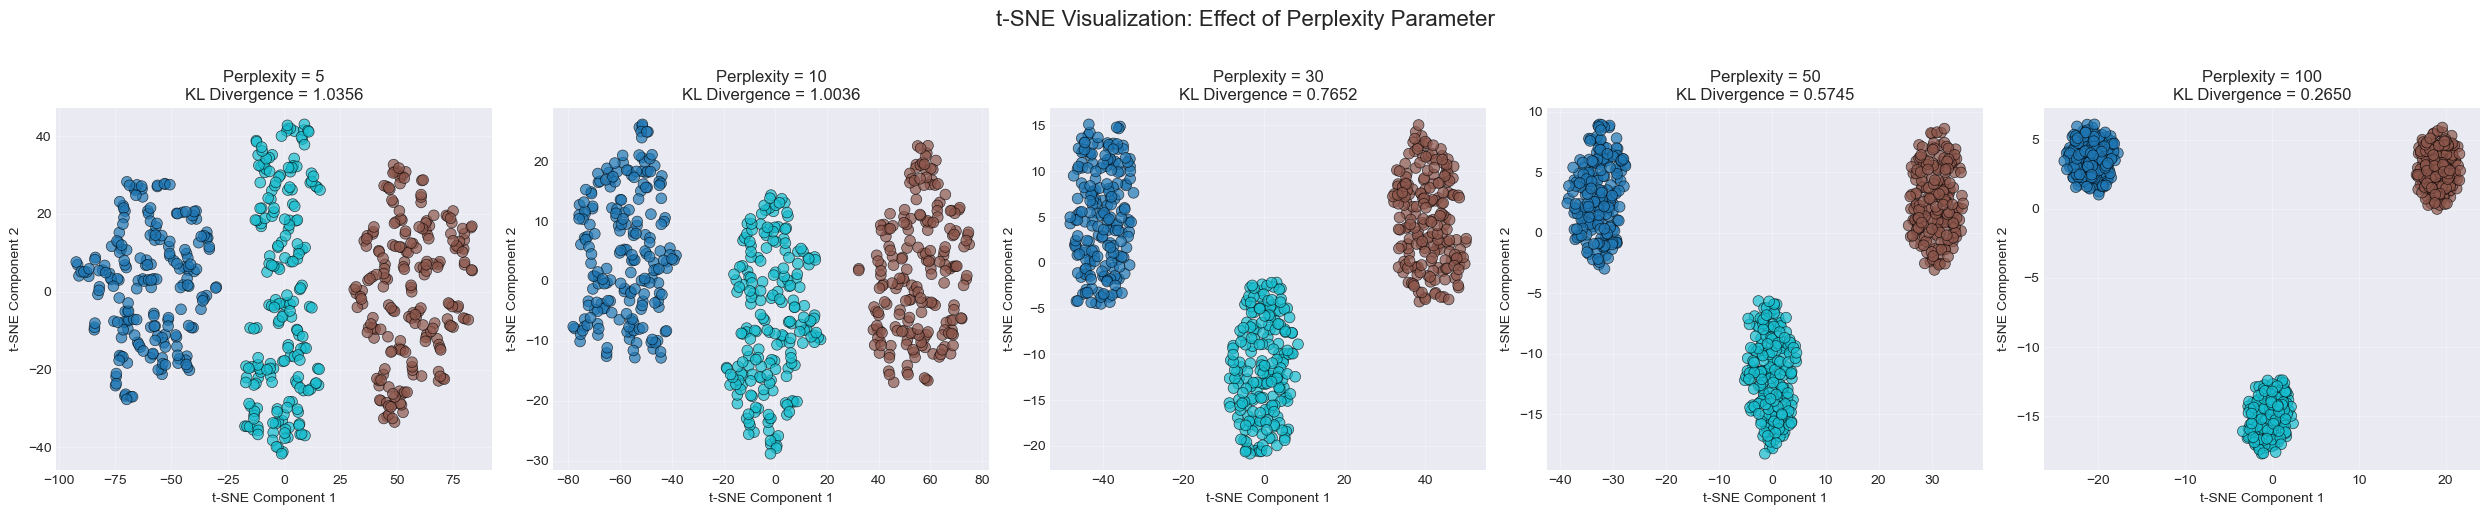

✓ 不同困惑度比較圖已儲存


In [11]:
# ========================================
# 5.1 繪製不同困惑度的 t-SNE 結果
# ========================================

fig, axes = plt.subplots(1, 5, figsize=(25, 5))

for i, perp in enumerate(perplexities):
    X_tsne = tsne_results[perp]['embedding']
    kl_div = tsne_results[perp]['kl_div']
    
    axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', 
                    alpha=0.7, edgecolors='k', linewidth=0.5, s=60)
    axes[i].set_title(f'Perplexity = {perp}\nKL Divergence = {kl_div:.4f}', fontsize=12)
    axes[i].set_xlabel('t-SNE Component 1', fontsize=10)
    axes[i].set_ylabel('t-SNE Component 2', fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('t-SNE Visualization: Effect of Perplexity Parameter', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / 'tsne_perplexity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 不同困惑度比較圖已儲存")

---
### 6. 最終 t-SNE 視覺化（最佳困惑度 = 30）

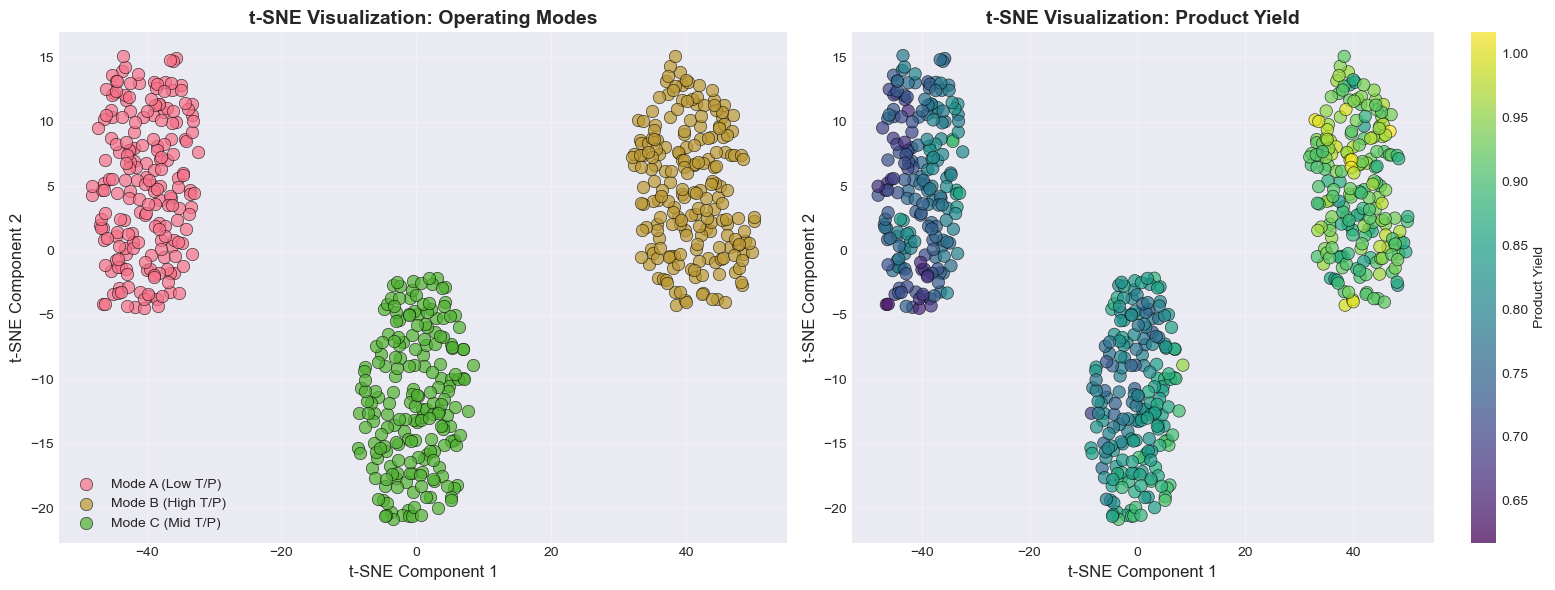

✓ 最終 t-SNE 視覺化圖已儲存


In [12]:
# ========================================
# 6.1 使用最佳困惑度繪製最終結果
# ========================================

best_perplexity = 30
X_tsne_final = tsne_results[best_perplexity]['embedding']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左圖：按操作模式著色
for i, mode_name in enumerate(mode_names):
    mask = labels == i
    axes[0].scatter(X_tsne_final[mask, 0], X_tsne_final[mask, 1], 
                    label=mode_name, alpha=0.7, edgecolors='k', linewidth=0.5, s=80)
axes[0].set_xlabel('t-SNE Component 1', fontsize=12)
axes[0].set_ylabel('t-SNE Component 2', fontsize=12)
axes[0].set_title('t-SNE Visualization: Operating Modes', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# 右圖：按產物產率著色（連續變量）
product_yield = df['Product_Yield'].values
scatter = axes[1].scatter(X_tsne_final[:, 0], X_tsne_final[:, 1], 
                          c=product_yield, cmap='viridis', 
                          alpha=0.7, edgecolors='k', linewidth=0.5, s=80)
axes[1].set_xlabel('t-SNE Component 1', fontsize=12)
axes[1].set_ylabel('t-SNE Component 2', fontsize=12)
axes[1].set_title('t-SNE Visualization: Product Yield', fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=axes[1])
cbar.set_label('Product Yield', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'tsne_final_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ 最終 t-SNE 視覺化圖已儲存")

---
### 7. t-SNE vs PCA 比較分析

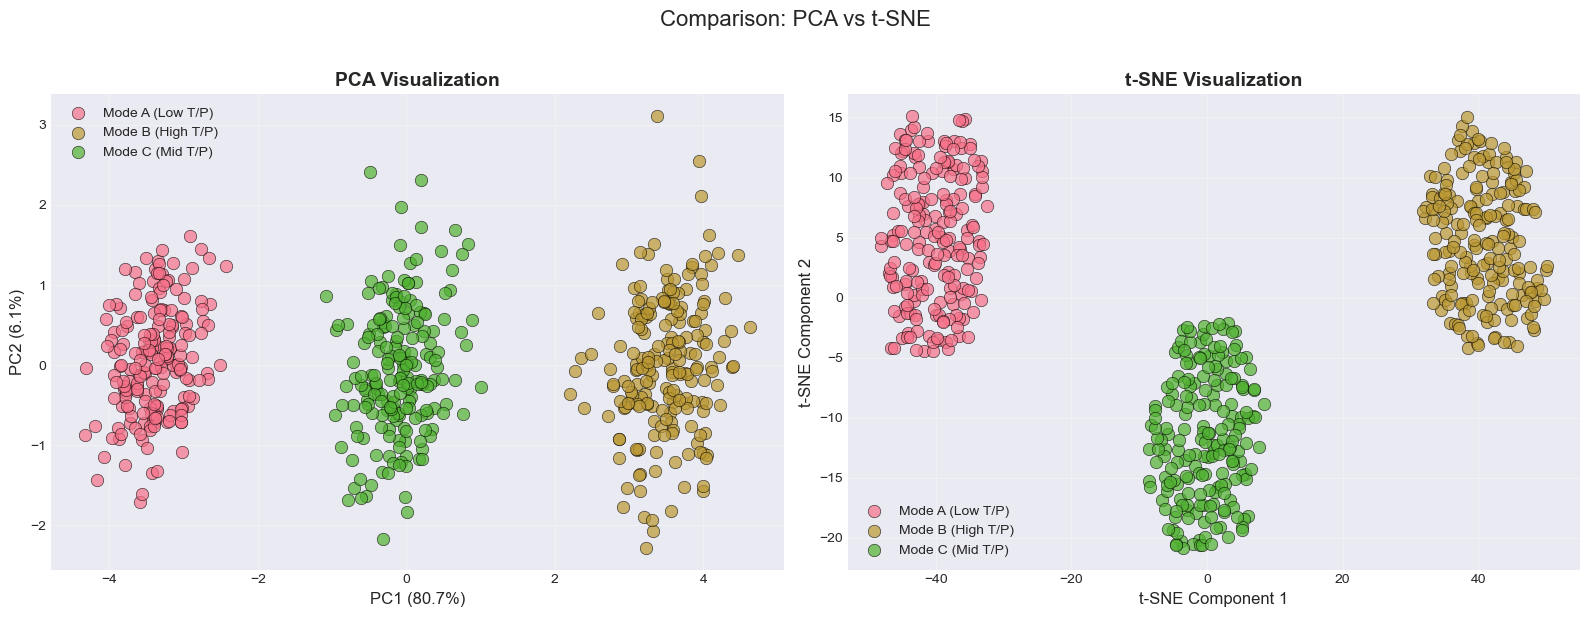

✓ PCA vs t-SNE 比較圖已儲存


In [13]:
# ========================================
# 7.1 使用 PCA 降維進行比較
# ========================================

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# 繪製比較圖
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 左圖：PCA
for i, mode_name in enumerate(mode_names):
    mask = labels == i
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                    label=mode_name, alpha=0.7, edgecolors='k', linewidth=0.5, s=80)
axes[0].set_xlabel('PC1 ({:.1f}%)'.format(pca.explained_variance_ratio_[0]*100), fontsize=12)
axes[0].set_ylabel('PC2 ({:.1f}%)'.format(pca.explained_variance_ratio_[1]*100), fontsize=12)
axes[0].set_title('PCA Visualization', fontsize=14, fontweight='bold')
axes[0].legend(loc='best', fontsize=10)
axes[0].grid(True, alpha=0.3)

# 右圖：t-SNE
for i, mode_name in enumerate(mode_names):
    mask = labels == i
    axes[1].scatter(X_tsne_final[mask, 0], X_tsne_final[mask, 1], 
                    label=mode_name, alpha=0.7, edgecolors='k', linewidth=0.5, s=80)
axes[1].set_xlabel('t-SNE Component 1', fontsize=12)
axes[1].set_ylabel('t-SNE Component 2', fontsize=12)
axes[1].set_title('t-SNE Visualization', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Comparison: PCA vs t-SNE', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(FIG_DIR / 'tsne_vs_pca_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ PCA vs t-SNE 比較圖已儲存")

---
### 8. 定量評估指標

In [14]:
# ========================================
# 8.1 計算評估指標
# ========================================

# PCA 評估
sil_pca = silhouette_score(X_pca, labels)
ch_pca = calinski_harabasz_score(X_pca, labels)

# t-SNE 評估
sil_tsne = silhouette_score(X_tsne_final, labels)
ch_tsne = calinski_harabasz_score(X_tsne_final, labels)

# 建立比較表
comparison_df = pd.DataFrame({
    '方法': ['PCA', 't-SNE'],
    '輪廓係數 (Silhouette Score)': [sil_pca, sil_tsne],
    'Calinski-Harabasz Score': [ch_pca, ch_tsne]
})

print("=" * 60)
print("定量評估指標比較")
print("=" * 60)
print(comparison_df.to_string(index=False))
print("=" * 60)
print("\n解讀:")
print("- 輪廓係數越接近 1 表示群集分離越好")
print("- Calinski-Harabasz Score 越高表示群集效果越好")
print(f"\n結論: t-SNE 的視覺化效果優於 PCA（輪廓係數: {sil_tsne:.3f} vs {sil_pca:.3f}）")

定量評估指標比較
   方法  輪廓係數 (Silhouette Score)  Calinski-Harabasz Score
  PCA                 0.695130              3100.700761
t-SNE                 0.801896              7807.328934

解讀:
- 輪廓係數越接近 1 表示群集分離越好
- Calinski-Harabasz Score 越高表示群集效果越好

結論: t-SNE 的視覺化效果優於 PCA（輪廓係數: 0.802 vs 0.695）


---
## 課程總結

### 本 Notebook 學習重點

1. **t-SNE 原理理解**：
   - t-SNE 是非線性降維方法，專為高維數據視覺化設計
   - 使用 KL 散度最小化保持局部相似性結構
   - 使用 t-分布解決擁擠問題

2. **超參數調整**：
   - **困惑度 (Perplexity)**：控制局部與全局結構的平衡
     - 小困惑度（5-10）：關注局部細節，產生更多小群集
     - 中困惑度（30-50）：平衡效果，通常最佳
     - 大困惑度（100）：關注全局結構，可能丟失局部細節
   - **學習率**：使用 'auto' 模式通常效果良好
   - **迭代次數**：至少 1000 次以確保收斂

3. **t-SNE vs PCA**：
   - **t-SNE**：視覺化效果優秀，群集分離清晰，適合探索性分析
   - **PCA**：速度快，可解釋性強，可投影新數據，適合製程監控
   - **組合使用**：PCA 預降維 + t-SNE 視覺化

4. **化工應用場景**：
   - 多操作模式的視覺化識別
   - 製程數據的探索性分析
   - 異常樣本的視覺化檢測
   - 高維光譜數據的視覺化

### 注意事項

- ✅ t-SNE 結果具有隨機性，使用 `random_state` 確保可重複性
- ✅ t-SNE 不保留全局結構，群集間距離無明確意義
- ✅ t-SNE 無法投影新數據，每次需重新運行
- ✅ 對於高維數據（> 50 維），建議先用 PCA 預降維

### 後續學習方向

- 探索 UMAP（t-SNE 的改進版本，速度更快，保留更多全局結構）
- 學習如何結合 t-SNE 與分群算法（K-Means, DBSCAN 等）
- 應用 t-SNE 於實際化工製程數據的視覺化分析
- 研究批次製程軌跡的降維視覺化技術